# Recipes for raster data

In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from IPython.display import Image
from rasterio.enums import Resampling

# Raster I/O and basic properties of raster data

In [2]:
suit = rasterio.open('./data/agrisuit.tif')

We can display a bunch of information about the data

In [3]:
suit.crs

CRS.from_epsg(4326)

In [4]:
suit.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

In [5]:
suit.transform

Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0)

## Affine transformations

Material summarizes discussion here:
https://medium.com/@mommermiscience/dealing-with-geospatial-raster-data-in-python-with-rasterio-775e5ba0c9f5

- raster data are arrays of pixels
- every pixel in the array is mapped to a geospatial location based on **affine transformation** and crs
- the affine transformation is stored in an `Affine` object
- defines how a change of 1 pixel in either direction (row / col) translates into crs coordinate changes using 6 parameters that are (in this order and all in the same units as the transformation's crs):
    - the change in $x$ as a function of the change in pixel column (+0.5 decimal degrees for +1 pixel)
    - change in $x$ as a function of the change in pixel row (0 decimal degrees for 1 pixel)
    - $x$-coordinate origin (-180 decimal degrees in this case)
    - change in $y$ as a function of the change in pixel column (0 decimal degrees for 1 pixel)
    - change in $y$ as a function of the change in pixel row (-0.5 decimal degrees for +1 pixel)
    - $y$-coordinate origin (90decimal degrees in this case)
- can consider transformation to consist of two parts:
    - a rotation matrix: in this case: $\begin{pmatrix} 0.5 & 0 \\ 0.0 & -0.5 \end{pmatrix}$ 
    - datasets's crs co-ordinate origin: in this case: $\begin{pmatrix} -180 \\ 90 \end{pmatrix}$
- see the cartoon (taken fromt he medium article) below:

<img src="data/affine.png" width=700 height=247 />

## plotting the data

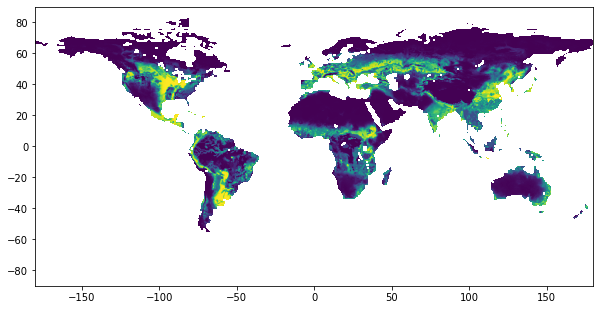

In [6]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit, ax=ax)
plt.show()

## bands

In [7]:
suit.indexes

(1,)

This dataset has only one band. With satellite images, you will often have more than one band

We can get the array of data as follows

In [8]:
array = suit.read(1)

In [9]:
array

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

Note that this is just a numpy array

In [10]:
type(array)

numpy.ndarray

But note tote that something is weird. Missing values seem to have been read as large negative values. 

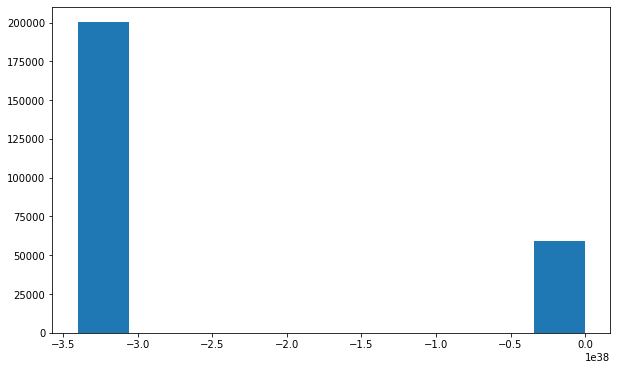

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(array.reshape(-1,1))
plt.show()

Fixing this:

In [12]:
array[array < 0] = np.nan

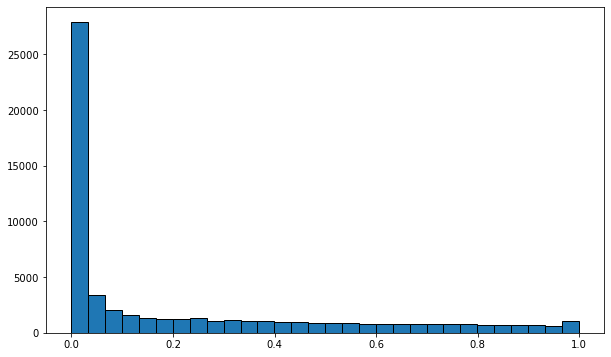

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(array.reshape(-1,1), bins=30, edgecolor='k')
plt.show()

## saving the corrected raster data

In [14]:
out_raster = rasterio.open('./data/agrisuit_corrected.tif',
                           'w',
                           driver='GTiff',
                           height=array.shape[0],
                           width=array.shape[1],
                           count=1,
                           dtype=array.dtype,
                           crs=suit.crs,
                           transform=suit.transform,
                          )
out_raster.write(array,1)
out_raster.close()

### reading again

In [15]:
suit = rasterio.open('./data/agrisuit_corrected.tif')

In [16]:
array = suit.read(1)

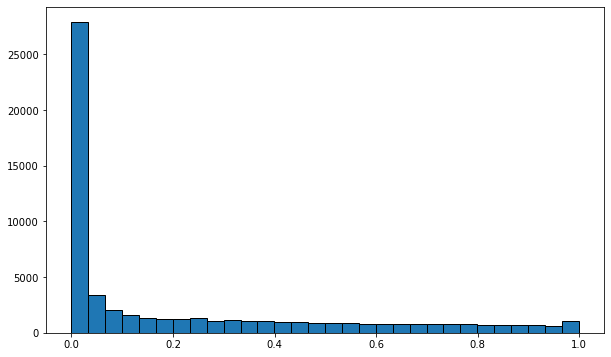

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(array.reshape(-1,1), bins=30, edgecolor='k')
plt.show()

In [18]:
array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

## Transformations between different image coordinates and crs coordinates
This is again taken from the medium article above

### from image co-ordinates to crs co-ordinates

In [19]:
row, col = 0, 0

In [20]:
x, y = suit.xy(row, col)

In [21]:
x, y

(-179.75, 89.75)

Note that this gives you the crs co-ordinates at the **center** of the pixel located in `row`, `column`. Another method is to just multiply (`row`, `column`) by the affine transformation:

In [22]:
x, y = suit.transform * (row, col)

In [23]:
x, y

(-180.0, 90.0)

This gives you a slightly different answer, since this gives you the answer relative to the origin co-ordinates of the transform.

## from crs co-ordinates to images co-ordinates

In [24]:
row, col = suit.index(-180, 90)

In [25]:
row, col

(0, 0)

In [26]:
suit.index(180, 90)

(0, 720)

In [27]:
suit.index(180, -90)

(360, 720)

In [28]:
array.shape

(360, 720)

This all makes sense, as we have a $0.5\times 0.5$ decimal degree raster (remember the rotation matrix?) with extent $[-180, -90, 180, 90]$.

# Raster math

Since the underlying array of raster values is just a `numpy` array, things couldnt be simpler:

## reclassifying raster values

In [29]:
binary_array = array.copy()
binary_array[binary_array >= 0.5] = 1
binary_array[binary_array < 0.5] = 0

<AxesSubplot:>

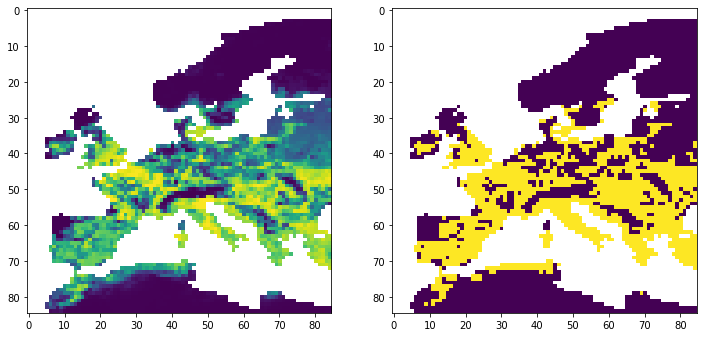

In [30]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
show(array[35:120, 335:420], ax=ax[0])
show(binary_array[35:120, 335:420], ax=ax[1])

## adding constants

In [31]:
transformed_array = array.copy()
transformed_array[transformed_array >= 0.5] = transformed_array[transformed_array >= 0.5] + 2

<AxesSubplot:>

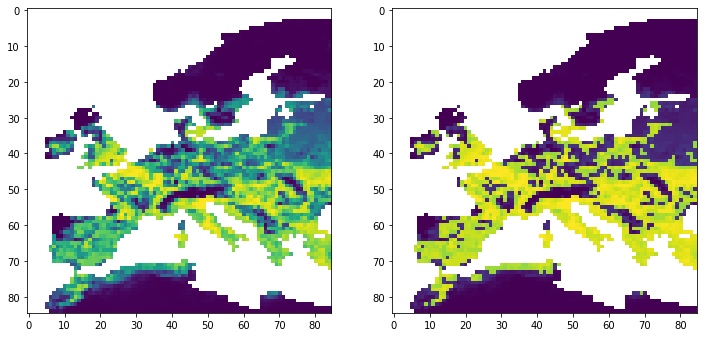

In [32]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
show(array[35:120, 335:420], ax=ax[0])
show(transformed_array[35:120, 335:420], ax=ax[1])

# Changing raster resolution

## upsamling

In [33]:
up_sample_factor = 2

In [34]:
finer_array = suit.read(
            out_shape=(
            suit.count,
            int(suit.height * up_sample_factor),
            int(suit.width * up_sample_factor)),
    resampling=Resampling.nearest
)

note there are different `resampling` algorithms possible. 
See here for details:
https://rasterio.readthedocs.io/en/latest/topics/resampling.html

In [35]:
transform = suit.transform * suit.transform.scale(
    (suit.width / finer_array.shape[-1]),
    (suit.height / finer_array.shape[-2]),
)

In [36]:
out_raster = rasterio.open('./data/agrisuit_finer.tif',
                           'w',
                           driver='GTiff',
                           height=finer_array.shape[0],
                           width=finer_array.shape[1],
                           count=1,
                           dtype=finer_array.dtype,
                           crs=suit.crs,
                           transform=transform,
                          )
out_raster.write(array,1)
out_raster.close()

In [37]:
suit_finer = rasterio.open('./data/agrisuit_finer.tif')

In [38]:
suit_finer.bounds

BoundingBox(left=-180.0, bottom=89.75, right=0.0, top=90.0)

In [39]:
suit_finer.crs

CRS.from_epsg(4326)

In [40]:
suit_finer.transform

Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 90.0)

<AxesSubplot:>

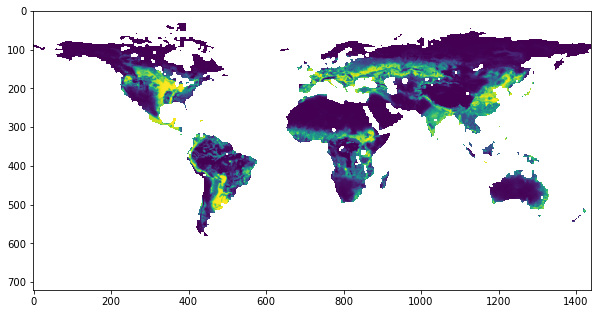

In [41]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
show(finer_array, ax=ax)

## downsampling

In [42]:
up_sample_factor = 0.1

In [43]:
coarser_array = suit.read(
            out_shape=(
            suit.count,
            int(suit.height * up_sample_factor),
            int(suit.width * up_sample_factor)),
    resampling=Resampling.nearest
)

In [44]:
transform = suit.transform * suit.transform.scale(
    (suit.width / coarser_array.shape[-1]),
    (suit.height / coarser_array.shape[-2]),
)

In [45]:
out_raster = rasterio.open('./data/agrisuit_coarser.tif',
                           'w',
                           driver='GTiff',
                           height=coarser_array.shape[0],
                           width=coarser_array.shape[1],
                           count=1,
                           dtype=coarser_array.dtype,
                           crs=suit.crs,
                           transform=transform,
                          )
out_raster.write(array,1)
out_raster.close()

In [46]:
suit_coarser = rasterio.open('./data/agrisuit_coarser.tif')

In [47]:
suit_coarser.bounds

BoundingBox(left=-180.0, bottom=85.0, right=0.0, top=90.0)

In [48]:
suit_coarser.crs

CRS.from_epsg(4326)

In [49]:
suit_coarser.transform

Affine(5.0, 0.0, -180.0,
       0.0, -5.0, 90.0)

<AxesSubplot:>

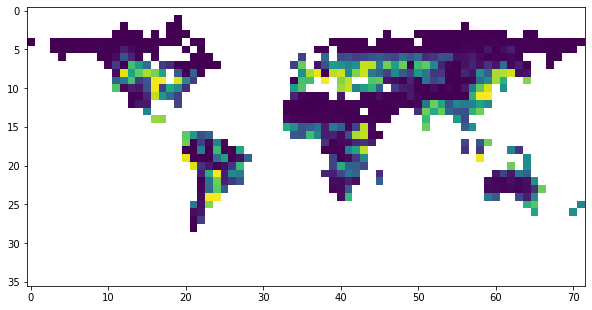

In [50]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
show(coarser_array, ax=ax)